In [1]:
import model, dataset, trainer, loss
from importlib import reload

import IPython.utils.io

from torchinfo import summary
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from scipy import stats

from matplotlib import pyplot as plt
import skimage
%pylab inline

from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gen_dataloader(bg, noise, batch_size, img_size):

    training_data = dataset.SingleImageDataset(np.ones(img_size)*bg, out_size=img_size, length=batch_size,
                                   image_params={'A':[1,1],
                                                 'bg':[0,0],
                                                 'x':[0, 0],
                                                 'y':[0, 0],
                                               # 'conv':np.ones((3,3)),
                                              },
                                   noise_params=noise,
                                   augmentations={}, normalize=False)
    # dataset.inspect_images(training_data)

    train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
    
    return train_dataloader

In [3]:
def gen_fitting_model(batch_size, img_size):
    fitting_model = model.BaseFitModel(
        renderer_class=model.PassthroughRenderer,
        encoder_class=model.IdEncoderModel,
        mapper_class=model.mapper.DirectImageMapperModel,
        img_size=img_size,
        fit_params=['ch0'],
        encoder_params={'num_img':batch_size, 'out_img_shape':img_size,
                        'init_weights':torch.zeros(img_size)},
    )
    
    # print(fitting_model.encoder.encoders['scale'].weight)
    # print(summary(fitting_model, input_size=(1,1,), row_settings=["var_names"], depth=4))
    
    return fitting_model

In [4]:
def extract_data(train_dataloader):
    data_iter = iter(train_dataloader)
    data = list()
    labels = dict()
    for d in data_iter:
        data.append(d[0])
        labels.update(d[1])
    data = torch.concat(data).view(-1)
    return data

In [5]:
# class CameraLoss(nn.Module):
#     def __init__(self, img_size, mle, gain=1, offset=100):
#         super().__init__()
#         self.img_size = img_size
#         self.mle = mle
        
#         gain = nn.Parameter(torch.ones(1) * gain)
#         # offset = nn.Parameter(torch.ones(1) * offset)
#         offset = nn.Parameter(torch.randn(1) * offset * 2)
#         self.camera = nn.ParameterDict({
#             'gain' : gain,
#             'offset' : offset,
#         })
        
#     def forward(self, input, target):
#         raise NotImplemented()
    
#     # def _predict(self, input):
#     #     pred = input * self.camera['gain']
#     #     pred = pred + self.camera['offset']
#     #     return pred
    
#     def _to_photons(self, target):
#         target = target - self.camera['offset']
#         target = target / self.camera['gain']
#         return target

    
# class L2CameraLoss(CameraLoss):
#     def __init__(self, img_size, gain=1, offset=100, **kwargs):
#         super().__init__(img_size=img_size, mle=False, gain=gain, offset=offset)
    
#     def forward(self, input, target, reduction='mean'):
#         # pred = self._predict(input)
#         # loss = nn.functional.mse_loss(pred, target, reduction=reduction)
#         target = self._to_photons(target)
#         loss = nn.functional.mse_loss(input, target, reduction=reduction)
#         return loss

    
# class L2PoissonWeightedCameraLoss(CameraLoss):
#     def __init__(self, img_size, gain=1, offset=100, var=0):
#         super().__init__(img_size=img_size, mle=False, gain=gain, offset=offset)
#         self.var = var
    
#     def forward(self, input, target, reduction='mean'):
#         var = torch.clamp(input, 0) + self.var
#         # pred = self._predict(input)
#         # loss = (target-pred)**2 / var
#         target = self._to_photons(target)
#         loss = (target-input)**2 / var
#         if reduction == 'mean':
#             loss = torch.mean(loss)
#         elif reduction == 'sum':
#             loss = torch.sum(loss)
#         else:
#             raise Exception("reduction method not recognized")
        
#         return loss


# class GaussMLECameraLoss(CameraLoss):
#     def __init__(self, img_size, gain=1, offset=100, var=0):
#         super().__init__(img_size=img_size, mle=True, gain=gain, offset=offset)
#         self.var = var
#         # var = torch.as_tensor(var)
#         # while var.ndim < 2:
#         #     var = var.unsqueeze(-1)
#         # self.register_buffer("var", var)
    
#     def forward(self, input, target, reduction='mean'):
#         # var = torch.clamp(input, 0) + self.var
#         # pred = self._predict(input)
#         target = self._to_photons(target)
#         loss = nn.functional.gaussian_nll_loss(input, target, torch.ones_like(input)*self.var, reduction=reduction)
#         return loss
    

# class GaussMLEPoissonWeightedCameraLoss(CameraLoss):
#     def __init__(self, img_size, gain=1, offset=100, var=0):
#         super().__init__(img_size=img_size, mle=True, gain=gain, offset=offset)
#         self.var = var
    
#     def forward(self, input, target, reduction='mean'):
#         var = torch.clamp(input, 0) + self.var
#         # pred = self._predict(input)
#         target = self._to_photons(target)
#         loss = nn.functional.gaussian_nll_loss(input, target, var, reduction=reduction)
#         return loss
    

# class GaussPoissonMLECameraLoss(CameraLoss):
#     def __init__(self, img_size, gain=1, offset=100, var=0):
#         super().__init__(img_size=img_size, mle=True, gain=gain, offset=offset)
#         self.var = var
        
#         self.losses = nn.ParameterDict({
#             'poisson' : nn.Parameter(torch.empty(self.img_size))
#         })
#         self.optimizer = torch.optim.LBFGS(self.losses.values(), lr=1.00,
#                                       max_iter=10, tolerance_grad=1e-3,
#                                      tolerance_change=1e-3,
#                                            history_size=10)
    
#     def forward(self, input, target, reduction='mean'):
#         # var = torch.clamp(input, 0) + self.var
#         # pred = self._predict(input)
#         target = self._to_photons(target)
#         # nn.functional.poisson_nll_loss(pred, target, log_input=False, reduction=reduction)
#         # loss = nn.functional.gaussian_nll_loss(pred, target, var, reduction=reduction)
#         pos_diff = torch.clamp(target - input, 0)
#         poisson_noise_proportion = torch.sqrt(input / (input + self.var))
#         with torch.no_grad():
#             # nn.init.kaiming_uniform_(self.losses['poisson'])
#             self.losses['poisson'].copy_((input + pos_diff * poisson_noise_proportion)[0,0])
            
#         self.optimizer.step(partial(self._nested_closure, input=input.detach(), target=target.detach()))
#         self.optimizer.zero_grad()
#         loss = self._calculate_nll(input, target)
#         return loss
    
#     def _calculate_nll(self, input, target):
#         poisson_noise = torch.round(torch.clamp(self.losses['poisson'], 0))
#         poisson_nll = nn.functional.poisson_nll_loss(input, poisson_noise, log_input=False, reduction='mean')
#         # poisson_nll = nn.functional.poisson_nll_loss(input, target, log_input=False, reduction='mean')
#         gauss_noise = target - poisson_noise
#         gauss_nll = nn.functional.gaussian_nll_loss(torch.zeros_like(gauss_noise), gauss_noise, torch.ones_like(gauss_noise)*self.var, reduction='mean')
#         return poisson_nll + gauss_nll
    
#     def _nested_closure(self, input, target):
#         self.optimizer.zero_grad()
#         # pred = fitting_model.call_auto(x, y)
#         # loss = loss_func(pred, x)
#         loss = self._calculate_nll(input, target)
#         # print(loss)
#         loss.backward()
#         return loss

In [6]:
def fit(loss_model, n=10, gt_background=10, gaussian=10, poisson=True, batch_size=32, img_size=(16,16)):
    res = {'gt': list(),
           'raw': list(),
           'fitted': list(),
           'fit_grad': list(),
           'hessian': list(),
           'error': list(),
           'loss': list(),
          }
    
    # gt_background = 10
    # gt_noise = {
    #     'gaussian': 10,
    #     'poisson': True,
    # }
    gt_noise = {}
    # if poisson is True:
    gt_noise['poisson'] = poisson
    if gaussian > 0:
        gt_noise['gaussian'] = gaussian
    
    bg = [gt_background,] * n
    noise = [gt_noise,] * n
    
    for i in range(n):
        train_dataloader = gen_dataloader(bg[i], noise[i], batch_size, img_size)
        fitting_model = gen_fitting_model(batch_size, img_size)

        loss_func = loss_model(gain=1, offset=gt_background, var=torch.as_tensor(gaussian**2 + gt_background))
        
        
        # optimizer = torch.optim.SGD(loss_func.parameters(), lr=0.5, momentum=0)
        optimizer = torch.optim.LBFGS([loss_func.camera.offset], lr=1.00,
                                      max_iter=200, tolerance_grad=1e-9,
                                     tolerance_change=1e-9)

        
        
        for j in range(2):
            for batch_i, (x, y) in enumerate(train_dataloader):
                def closure():
                    optimizer.zero_grad()
                    pred = fitting_model.call_auto(x, y)
                    loss = loss_func(pred, x)
                    # print(loss)
                    loss.backward()
                    return loss
                print("outer pre-closure")
                optimizer.step(closure)
                print("outer post-closure")
                optimizer.zero_grad()
                pred = fitting_model.call_auto(x, y)
                loss = loss_func(pred, x)
                grad = torch.autograd.grad(loss, loss_func.camera.offset, retain_graph=True, create_graph=True)
                # print('grad', grad)
                hess = torch.autograd.grad(grad, loss_func.camera.offset)[0]
                # print(hess)
                # cov = 1/hess[0]
                # # print(pred.shape, x.shape)
                # # error = torch.sqrt(cov * loss_func.cal_mse(pred, x) / (32*2*2-1))
                # # error = torch.sqrt(2 * cov * loss_func.cal_rss(pred, x).unsqueeze(0) / (batch_size * prod(img_size)-1))
                # loss = loss_func(pred, x, full=True, reduction='full').unsqueeze(0) / (batch_size * prod(img_size)-1)
                # # error = torch.sqrt( cov * loss_func(pred, x, full=True, reduction='sum').unsqueeze(0) / (batch_size * prod(img_size)-1))
                # # error = torch.sqrt( cov * loss_func(pred, x, full=True, reduction='mean').unsqueeze(0))
                # error = torch.sqrt(2 * cov * loss)
                # # print('mse', loss_func.cal_mse(pred, x))
                # # print('error', error)
                cov = hess.unsqueeze(-1).inverse()
                if loss_func.mle:
                    error = torch.sqrt(torch.diag(cov) / (batch_size * prod(img_size) - 1))
                else:
                    # cov /= cov.sum()
                    cov *= 2
                    error = torch.sqrt(torch.diag(cov) * loss_func(pred, x, reduction='sum')) / (batch_size * prod(img_size) - 1)
                    # error = torch.sqrt(torch.diag(cov) * loss_func.cal_rss(pred, x).unsqueeze(0) / (batch_size * prod(img_size)-1))
                # print(error.shape)
                # print(loss)
                       
        res['gt'].append(np.asarray([bg[i]]))
        res['raw'].append(extract_data(train_dataloader).reshape(1,-1))
        res['fitted'].append(loss_func.camera.offset.detach().numpy())
        res['fit_grad'].append(loss_func.camera.offset.grad.detach().numpy())
        res['hessian'].append(hess.detach().numpy())
        res['error'].append(error.detach().numpy())
        res['loss'].append(loss.unsqueeze(0).detach().numpy())
    
    for key, val in res.items():
        # print(key)
        res[key] = np.concatenate(val)
        
    res['loss_model'] = loss_model.__name__
    res['n'] = n
    res['bg'] = gt_background
    res['gaussian'] = gaussian
    res['poisson'] = poisson
    res['batch_size'] = batch_size
    res['img_size'] = img_size
        
    return res

In [7]:
def visualize(res):
    fig, axes = subplots(3, 3, figsize=(12, 12), squeeze=False)
    
    axes[0,0].axvline(res['gt'].mean(), color='red', ls='--', lw=2, zorder=1)
    axes[0,0].boxplot(res['raw'].flatten(), notch=True, vert=False, labels=[''], patch_artist=True, zorder=2)
    axes[0,0].set_xlabel('pixel intensity')
    axes[0,0].set_title('raw')
    
    axes[0,1].hist(res['raw'].reshape(-1), 100)
    axes[0,1].axvline(res['gt'].mean(), color='red', ls='--', lw=2, label='gt')
    axes[0,1].axvline(res['raw'].mean(), color='black', ls=':', lw=2, label='raw')
    axes[0,1].set_xlabel('pixel intensity')
    axes[0,1].set_ylabel('counts')
    axes[0,1].set_title('raw')
    
    def build_str(label, mean, var):
        texts = [label + ':',
                 "mean = {:.3f}".format(mean),
                 "var = {:.3f}".format(var),
                 "std = {:.3f}".format(np.sqrt(var)),
                ]
        texts = '\n'.join(texts)
        return texts
    
    mean = res['bg']
    var = res['gaussian']**2 + (res['bg'] if res['poisson'] else 0)
    # print(res['gaussian'], var)
    expect_string = build_str("Expected", mean, var)
    
    mean = res['raw'].mean()
    var = res['raw'].var(ddof=1)
    observe_string =  build_str("Observed", mean, var)
    axes[0,2].text(0.5, 0.5, "\n\n".join(["Raw", expect_string, observe_string]), va='center', ha='center', transform=axes[0,2].transAxes)
    
    axes[1,0].axvline(res['gt'].mean(), color='red', ls='--', lw=2, zorder=1)
    axes[1,0].boxplot(res['fitted'].flatten(), notch=True, vert=False, labels=[''], patch_artist=True, zorder=2)
    axes[1,0].set_xlabel('bg intensity')
    axes[1,0].set_title('fit')
    
    axes[1,1].hist(res['fitted'], 100)
    axes[1,1].axvline(res['gt'].mean(), color='red', ls='--', lw=2, label='gt')
    axes[1,1].axvline(res['fitted'].mean(), color='black', ls=':', lw=2, label='fit')
    axes[1,1].set_xlabel('bg intensity')
    axes[1,1].set_ylabel('counts')
    axes[1,1].set_title('fit')
    
    mean = res['bg']
    var = (res['gaussian']**2 + (res['bg'] if res['poisson'] else 0)) / (res['batch_size'] * prod(res['img_size']))
    expect_string = build_str("Expected", mean, var)
    
    mean = res['fitted'].mean()
    var = res['fitted'].var(ddof=1)
    observe_string =  build_str("Observed", mean, var)
    axes[1,2].text(0.5, 0.5,
                   "\n\n".join(["n={}".format(res['batch_size'] * prod(res['img_size'])),
                                expect_string, observe_string]), va='center', ha='center', transform=axes[1,2].transAxes)
    
    axes[2,0].hist(res['hessian'], 100)
    axes[2,0].set_xlabel('Hessian')
    axes[2,0].set_ylabel('counts')
    axes[2,0].set_title('fit')    
    
    axes[2,1].axvline(res['error'].mean(), color='black', ls=':', lw=2, label='fit')
    axes[2,1].hist(res['error'], 100)
    axes[2,1].set_xlabel('error')
    axes[2,1].set_ylabel('counts')
    axes[2,1].set_title('fit')

    c = np.abs((res['fitted'] - res['gt']) / res['error']) / stats.norm.ppf(0.975)
    c = c < 1    
    axes[2,2].axvline(res['fitted'].mean(), color='black', ls=':', lw=2, label='fit')
    axes[2,2].scatter(res['fitted'][c], res['error'][c], color='green')
    axes[2,2].scatter(res['fitted'][~c], res['error'][~c], color='red')
    axes[2,2].text(0.05, 0.05, 'Target: 0.950\nActual: {:.3f}'.format(c.sum()/c.size), transform=axes[2,2].transAxes)
    # axes[1,1].set_aspect(1/res['error'].mean() * stats.norm.ppf(0.975))
    axes[2,2].set_xlabel('bg intensity')
    axes[2,2].set_ylabel('error')
    axes[2,2].set_title('fit')    
    
    fig.suptitle(res['loss_model'])
    
    fig.tight_layout()

In [8]:
# with IPython.utils.io.capture_output() as captured:
#     res = fit(TestLoss, 1000, 1000, 0, True, batch_size=1, img_size=(32,32))
# # res = fit(1, 10, 1, False)
# print('done')

In [9]:
# # data_var = np.mean(np.square(res['raw'].reshape(-1)-res['gt'].mean()))
# # sample_var = np.mean(np.square(res['fitted']-res['gt']))
# # sample_mean = np.mean(res['fitted'])
# # print(data_var, sample_var, np.sqrt(sample_var))
# # print(sample_mean + np.asarray([-1,1]) * stats.norm.ppf(0.975)*sample_var)
# visualize(res)

In [10]:
def test(loss_model, n=1000, gt_background=1000, gaussian=100, poisson=False, batch_size=1, img_size=(2,2)):
    with IPython.utils.io.capture_output() as captured:
        res = fit(loss_model, n=n, gt_background=gt_background, gaussian=gaussian, poisson=poisson, batch_size=batch_size, img_size=img_size)    
    visualize(res)
    return res

C:\Users\Kenny\AppData\Local\Temp/ipykernel_21944/492374733.py:69: RuntimeWarning: divide by zero encountered in true_divide
  c = np.abs((res['fitted'] - res['gt']) / res['error']) / stats.norm.ppf(0.975)
C:\Users\Kenny\AppData\Local\Temp/ipykernel_21944/492374733.py:69: RuntimeWarning: divide by zero encountered in true_divide
  c = np.abs((res['fitted'] - res['gt']) / res['error']) / stats.norm.ppf(0.975)


''

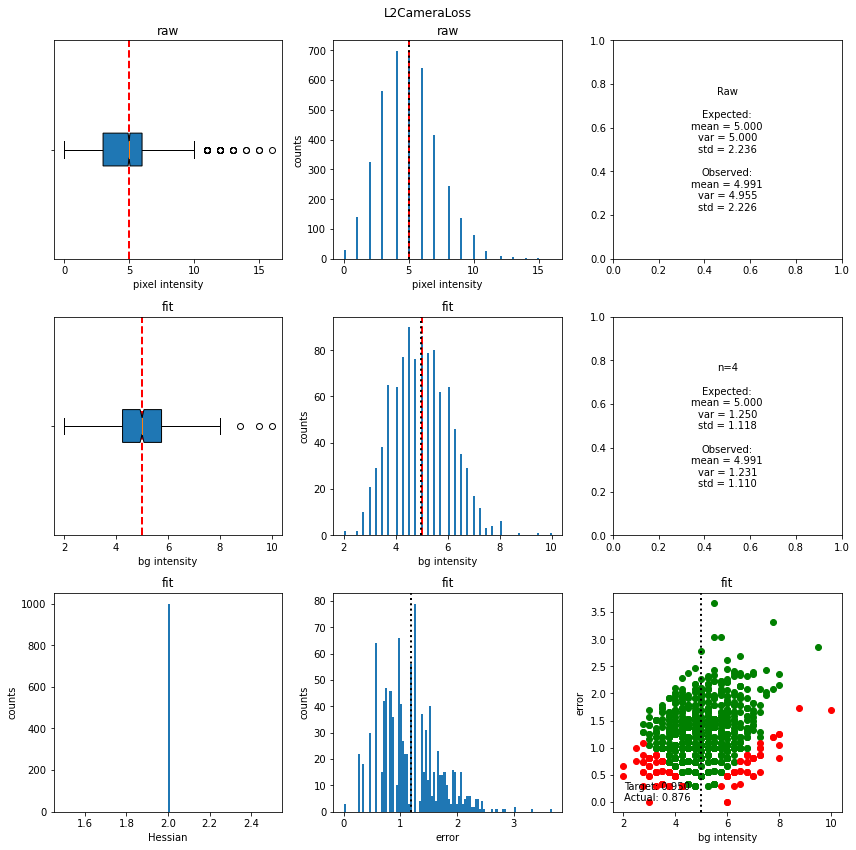

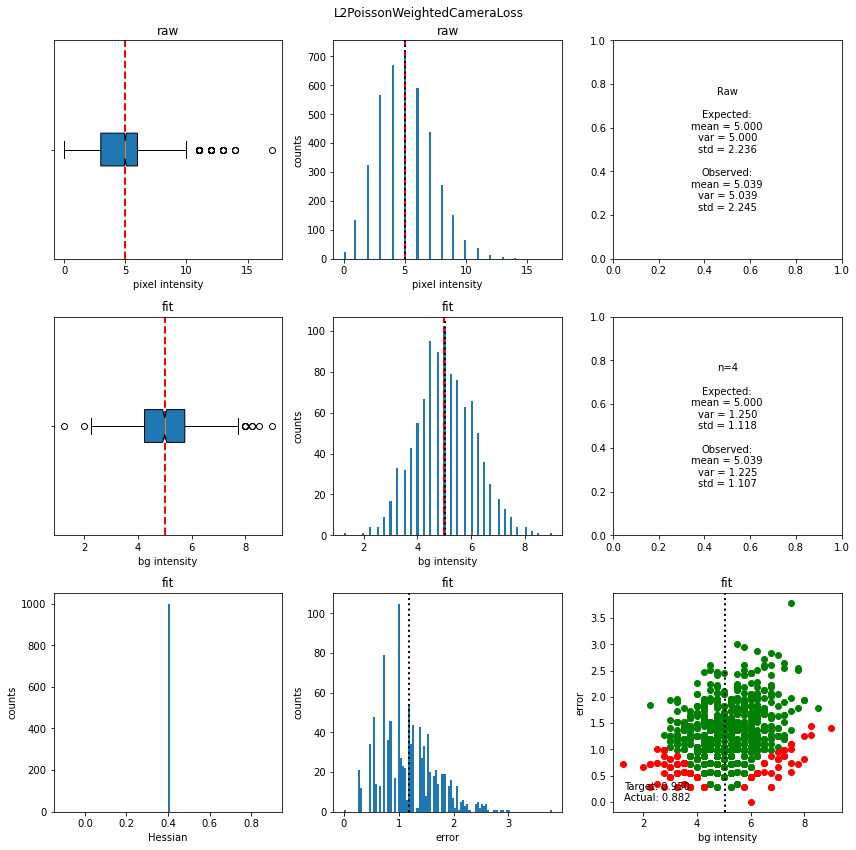

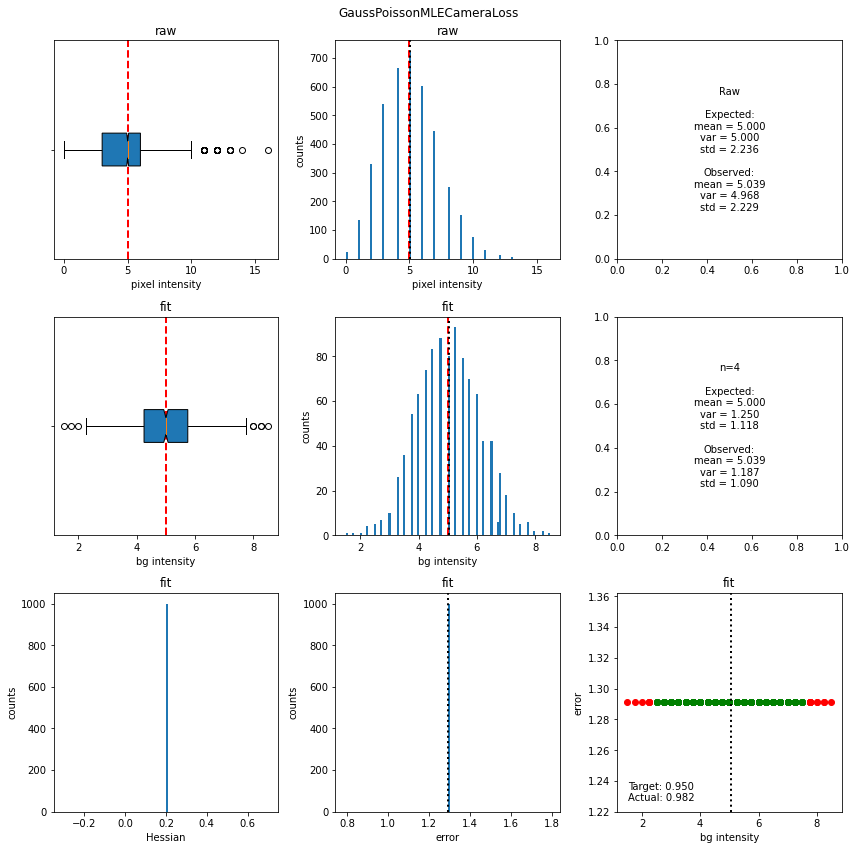

In [11]:
params = {
    'n': 1000,
    'gt_background': 5,
    'gaussian': 0,
    'poisson': True,
}

test(loss.L2CameraLoss, **params)
test(loss.L2PoissonWeightedCameraLoss, **params)
# test(loss.GaussMLECameraLoss, **params)
# test(loss.GaussMLEPoissonWeightedCameraLoss, **params)
test(loss.GaussPoissonMLECameraLoss, **params)
;

''

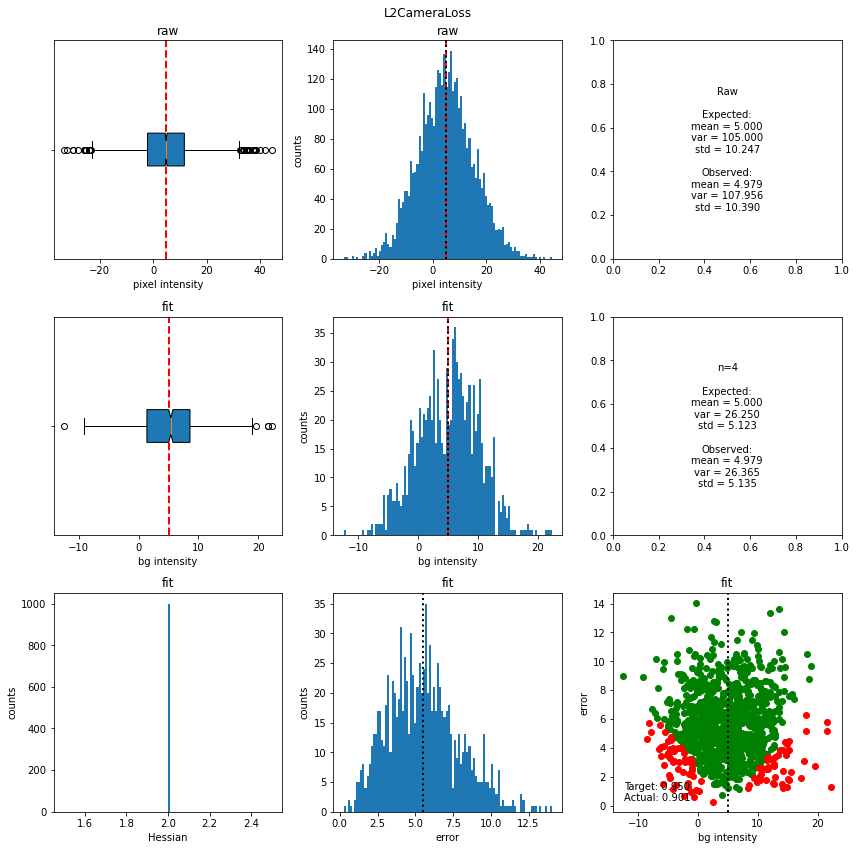

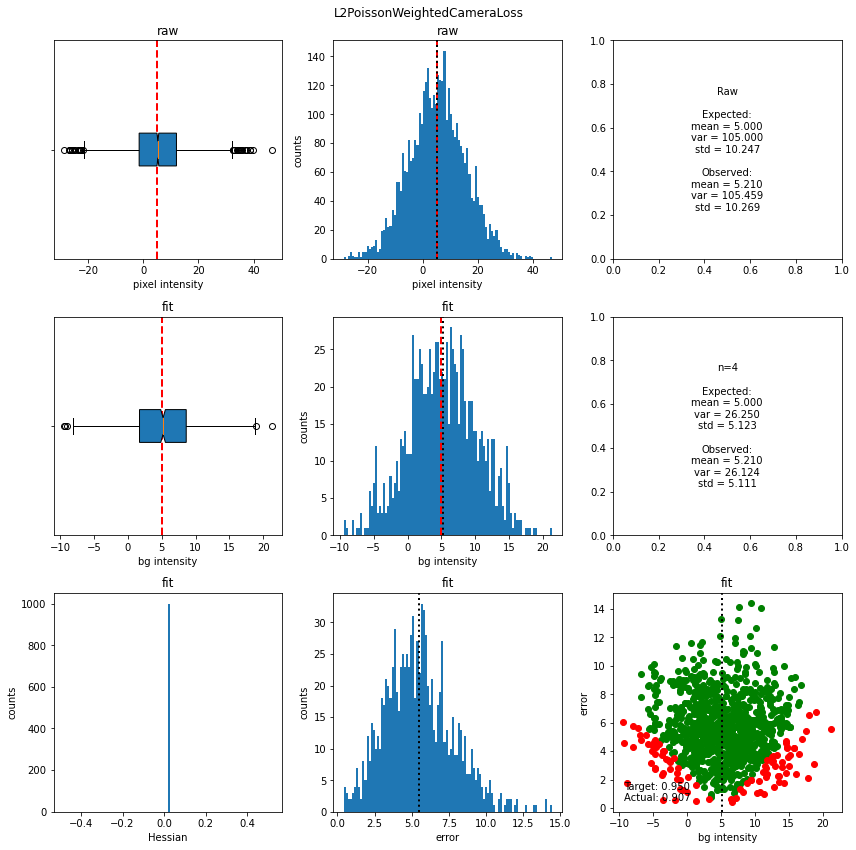

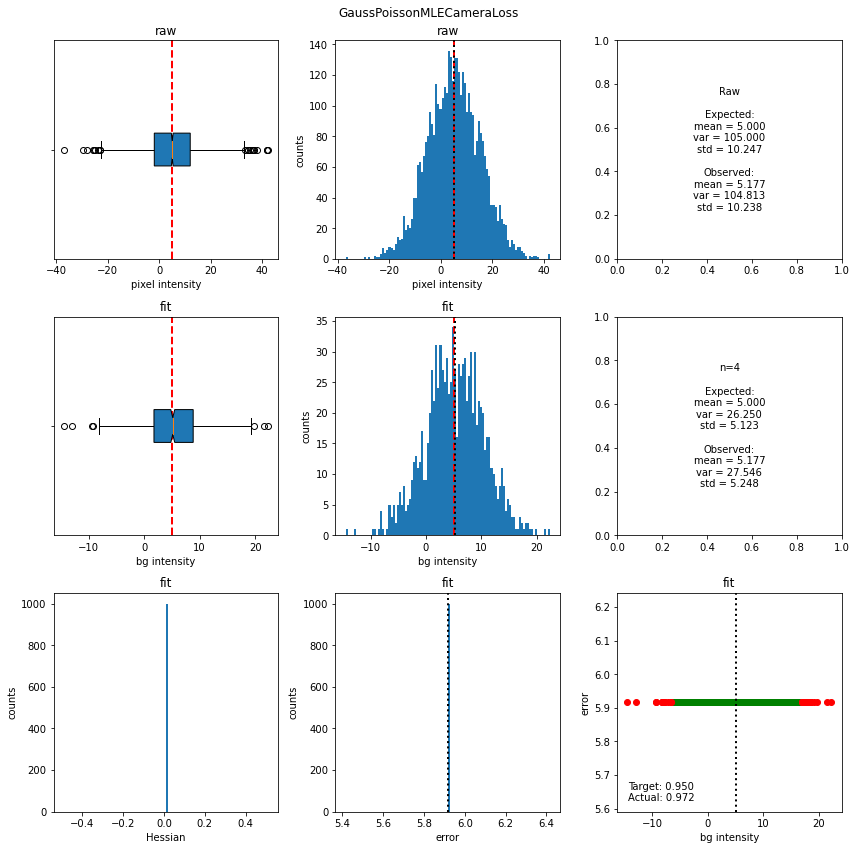

In [12]:
params = {
    'n': 1000,
    'gt_background': 5,
    'gaussian': 10,
    'poisson': True,
}

test(loss.L2CameraLoss, **params)
test(loss.L2PoissonWeightedCameraLoss, **params)
# test(loss.GaussMLECameraLoss, **params)
# test(loss.GaussMLEPoissonWeightedCameraLoss, **params)
test(loss.GaussPoissonMLECameraLoss, **params)
;

''

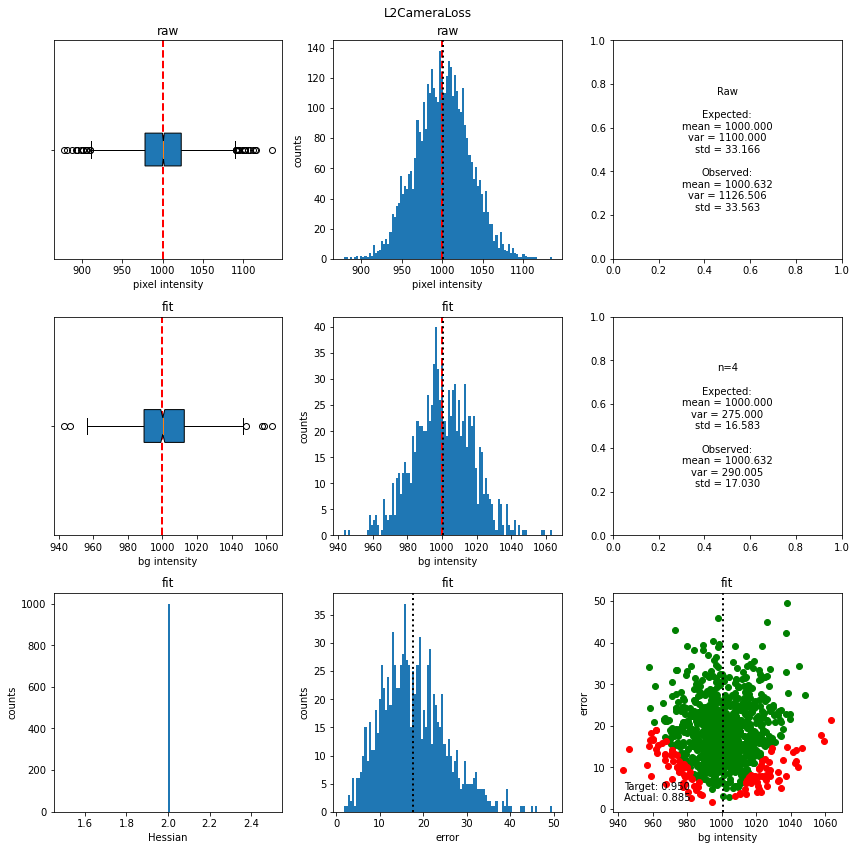

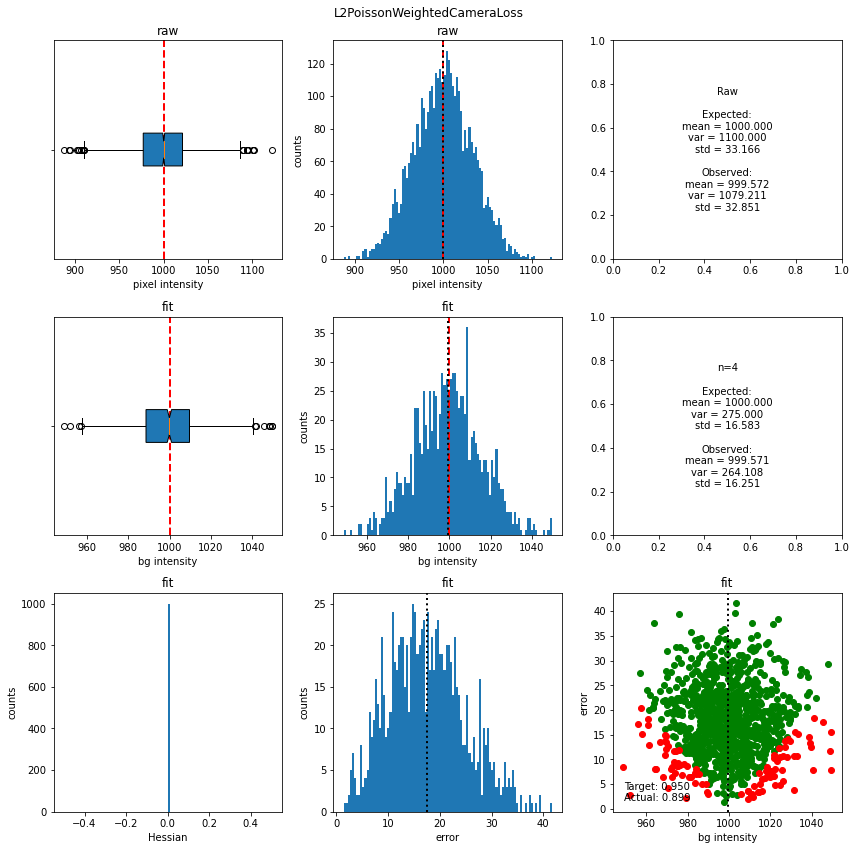

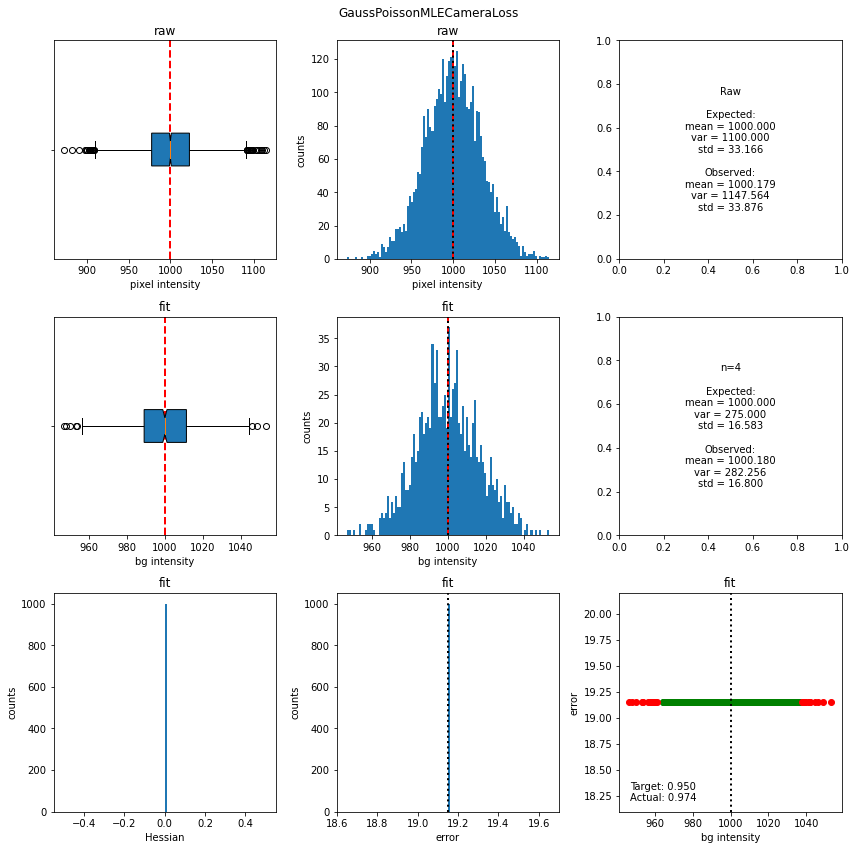

In [13]:
params = {
    'n': 1000,
    'gt_background': 1000,
    'gaussian': 10,
    'poisson': True,
}

test(loss.L2CameraLoss, **params)
test(loss.L2PoissonWeightedCameraLoss, **params)
# test(loss.GaussMLECameraLoss, **params)
# test(loss.GaussMLEPoissonWeightedCameraLoss, **params)
test(loss.GaussPoissonMLECameraLoss, **params)
;

In [14]:
# params = {
#     'n': 100,
#     'gt_background': 1000,
#     'gaussian': 10,
#     'poisson': True,
# }

# l2loss_res = test(L2CameraLoss, **params)
# l2poisson_res = test(L2PoissonWeightedCameraLoss, **params)
# mle_res = test(GaussMLECameraLoss, **params)
# mle_res = test(GaussMLEPoissonWeightedCameraLoss, **params)
# mle_res = test(GaussPoissonMLECameraLoss, **params)


# %timeit test(L2CameraLoss, **params)
# %timeit test(L2PoissonWeightedCameraLoss, **params)
# %timeit test(GaussMLECameraLoss, **params)
# %timeit test(GaussMLEPoissonWeightedCameraLoss, **params)
# %timeit test(GaussPoissonMLECameraLoss, **params)

# test(loss.L2CameraLoss, **params)
# test(loss.L2PoissonWeightedCameraLoss, **params)
# test(loss.GaussMLECameraLoss, **params)
# test(loss.GaussMLEPoissonWeightedCameraLoss, **params)
# test(loss.GaussPoissonMLECameraLoss, **params)
# ;